<a href="https://colab.research.google.com/github/Fordreign/my_works/blob/main/AE_dz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

%matplotlib inline

In [ ]:
random_state=69

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from sklearn.model_selection import train_test_split
train_photos, val_photos= train_test_split(data, train_size=0.9, shuffle=False, random_state=random_state)

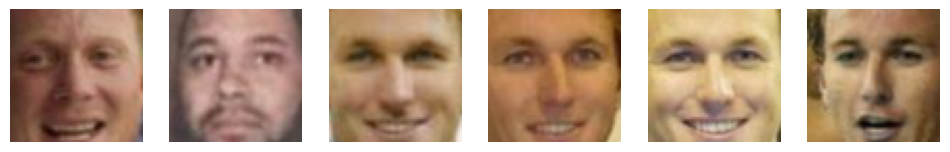

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis('off')
    plt.imshow(train_photos[i+1])

In [ ]:
train_photos = np.moveaxis(train_photos, -1, 1)
val_photos = np.moveaxis(val_photos, -1, 1)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_photos).float())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_photos).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code =  1024# выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=64):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )

        # Latent
        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, dim_code)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, sample):
        encoded = self.encoder(sample)
        latent_code = self.latent(encoded)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

    def sample(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder(dim_code=dim_code).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters()) # Ваш любимый оптимизатор>

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

  0%|          | 0/50 [00:00<?, ?it/s]

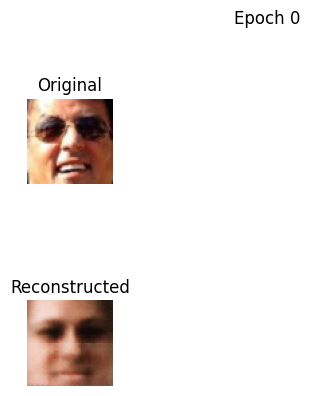

 20%|██        | 10/50 [00:33<01:46,  2.67s/it]

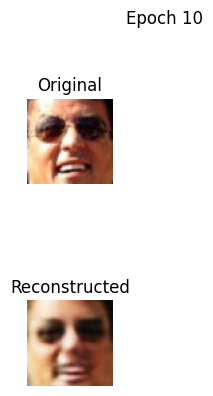

 40%|████      | 20/50 [00:58<01:17,  2.60s/it]

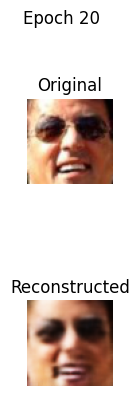

 60%|██████    | 30/50 [01:23<00:50,  2.51s/it]

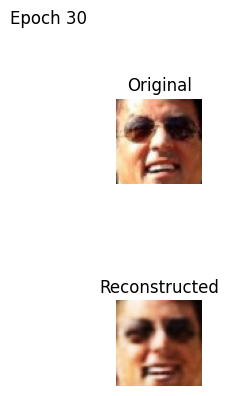

 80%|████████  | 40/50 [01:49<00:25,  2.55s/it]

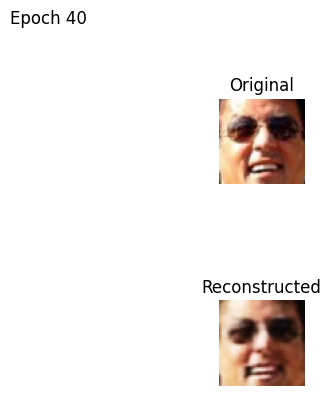

 98%|█████████▊| 49/50 [02:11<00:02,  2.47s/it]

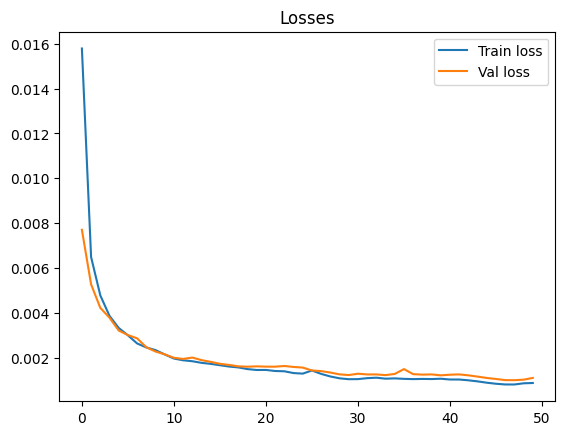

100%|██████████| 50/50 [02:14<00:00,  2.69s/it]


In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        X_batch = X_batch[0].to(device) 
        optimizer.zero_grad()
        reconstructed, latent_code = autoencoder(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, X_batch in enumerate(val_loader):
            X_batch = X_batch[0].to(device) 
            reconstructed, _ = autoencoder(X_batch)
            loss = criterion(reconstructed, X_batch)
            val_losses_per_epoch.append(loss.item())
            if i == 0 and epoch % 10 == 0:
                plt.subplot(2, 5, epoch//10 + 1)
                plt.imshow(X_batch[0].cpu().permute(1,2,0))
                plt.title("Original")
                plt.axis("off")
                plt.subplot(2, 5, epoch//10 + 6)
                plt.imshow(reconstructed[0].cpu().permute(1,2,0))
                plt.title("Reconstructed")
                plt.axis("off")
                
    val_losses.append(np.mean(val_losses_per_epoch))
    
    if epoch == n_epochs - 1:
        plt.plot(train_losses, label="Train loss")
        plt.plot(val_losses, label="Val loss")
        plt.legend()
        plt.title("Losses")
        plt.show()

    if epoch % 10 == 0:
        plt.suptitle(f"Epoch {epoch}")
        plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

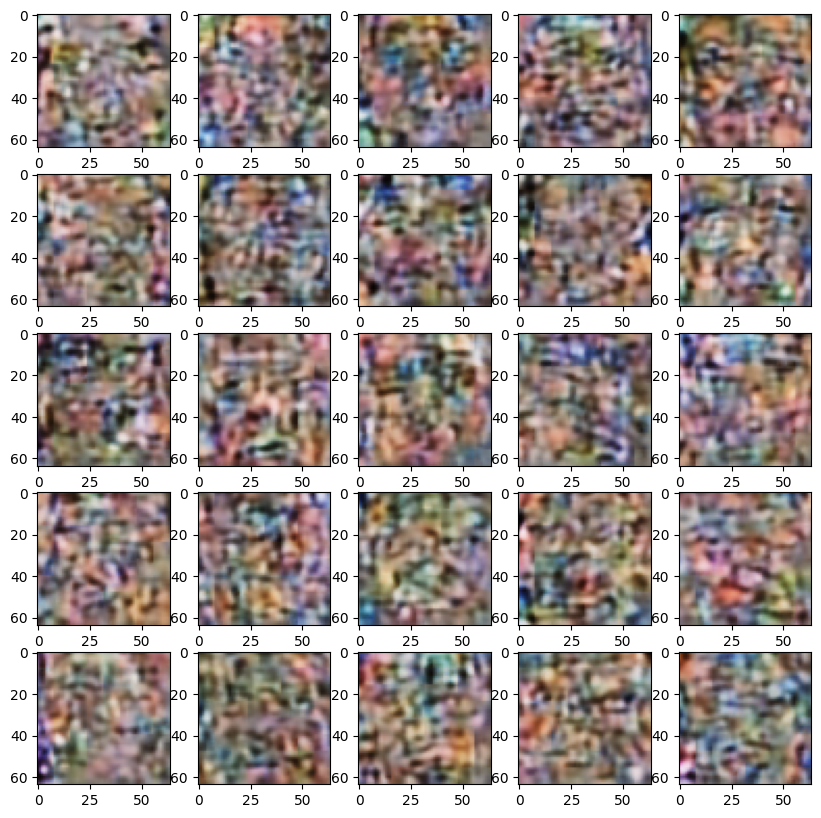

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    generated = np.transpose(generated, (1, 2, 0))
    plt.imshow(generated)

plt.show()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Каждой строке из data соответсвует значение аттрибутов из attrs
# Давайте найдем 20 улыбающихся и 20 грустных возьмем разность их латентных векторов и затем приделаем их к грустным

In [ ]:
data.shape

(13143, 64, 64, 3)

In [ ]:
attrs.shape

(13143, 73)

In [ ]:
data[0].shape

(64, 64, 3)

In [ ]:
attrs.Smiling.head()

0    -0.86499
1    0.798544
2    0.172817
3    0.563327
4    0.507786
Name: Smiling, dtype: object

In [ ]:
smile_index = attrs.sort_values(by='Smiling', ascending=False).head(100).index
sad_index = attrs.sort_values(by=['Frowning','Smiling','Arched Eyebrows','Mouth Closed'], ascending=False).head(100).index

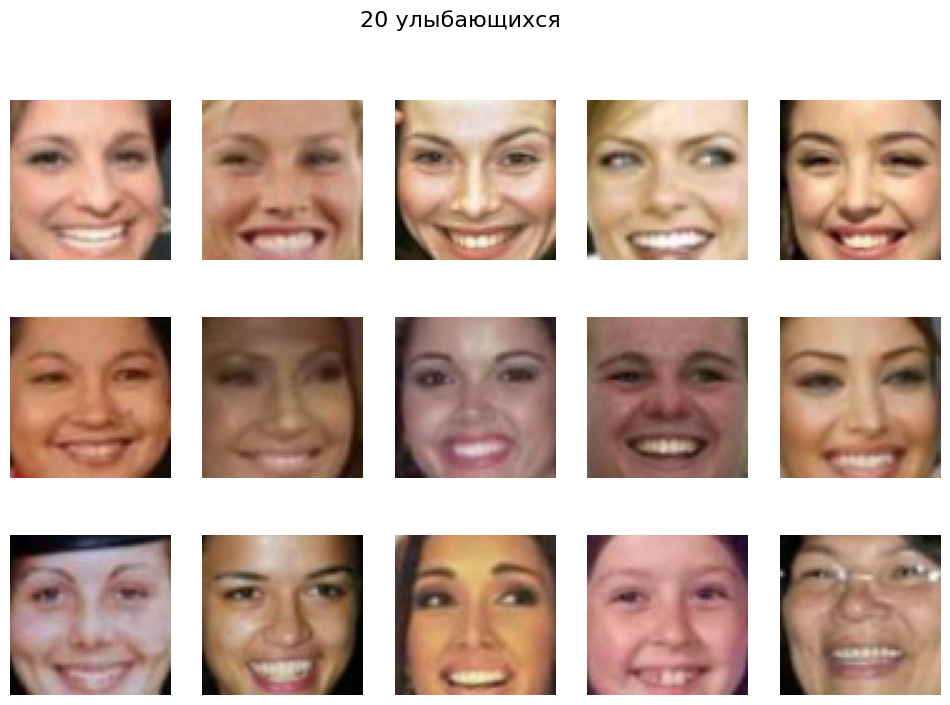

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
fig.suptitle('20 улыбающихся', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(data[smile_index][i])
    ax.set_axis_off()

plt.show()

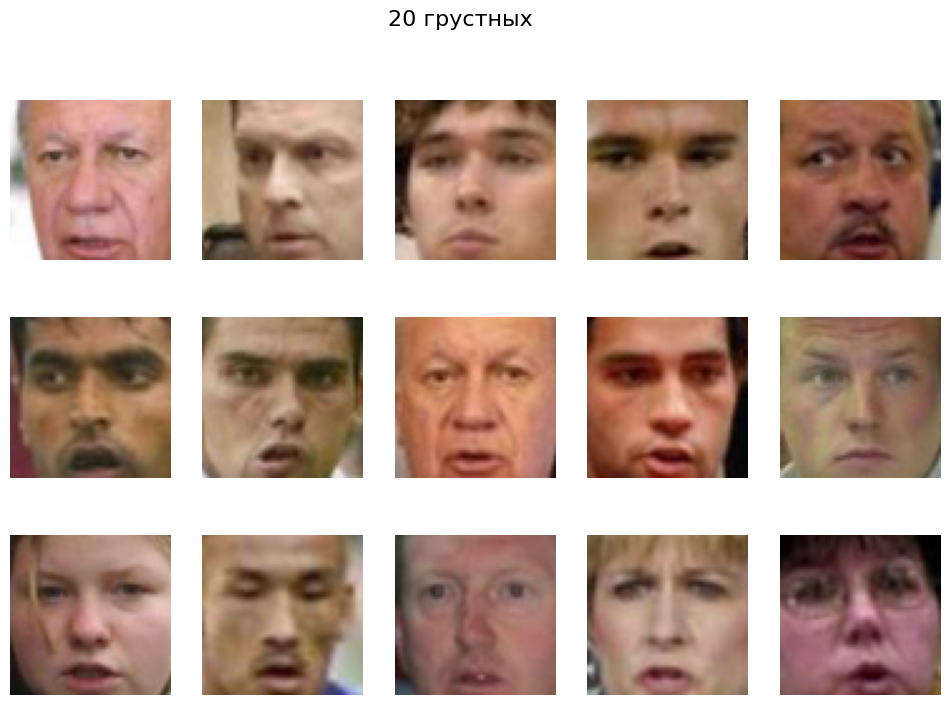

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
fig.suptitle('20 грустных', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(data[sad_index][i])
    ax.set_axis_off()

plt.show()

In [ ]:
data_sad = data[sad_index]
data_smile = data[smile_index]

In [ ]:
data_smile.shape

(100, 64, 64, 3)

In [ ]:
data_smile = np.transpose(data_smile, (0,3, 1, 2))
data_sad = np.transpose(data_sad, (0, 3, 1, 2))

In [ ]:
# Преобразовываем numpy ndarray в PyTorch Tensor
data_smile_tensor = torch.from_numpy(data_smile).float().to(device)
data_sad_tensor = torch.from_numpy(data_sad).float().to(device)

# Прогоняем через модель
with torch.no_grad():
    encoded_smile = autoencoder.encoder(data_smile_tensor)
    encoded_smile = autoencoder.latent(encoded_smile)

    encoded_sad = autoencoder.encoder(data_sad_tensor)
    encoded_sad = autoencoder.latent(encoded_sad)

# Считаем средние латентные представления для улыбающихся и грустных лиц
mean_encoded_smile = encoded_smile.mean(dim=0)
mean_encoded_sad = encoded_sad.mean(dim=0)

# Вычисляем разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей
latent_diff = mean_encoded_smile - mean_encoded_sad
new_latent = encoded_sad + latent_diff

# Прогоняем новые латентные представления через декодер
with torch.no_grad():
    reconstructed_images = autoencoder.decoder(new_latent)

# Переносим тензор на CPU и изменяем порядок осей в массивах обратно
reconstructed_images = reconstructed_images.cpu().numpy()
reconstructed_images = np.transpose(reconstructed_images, (0, 2, 3, 1))

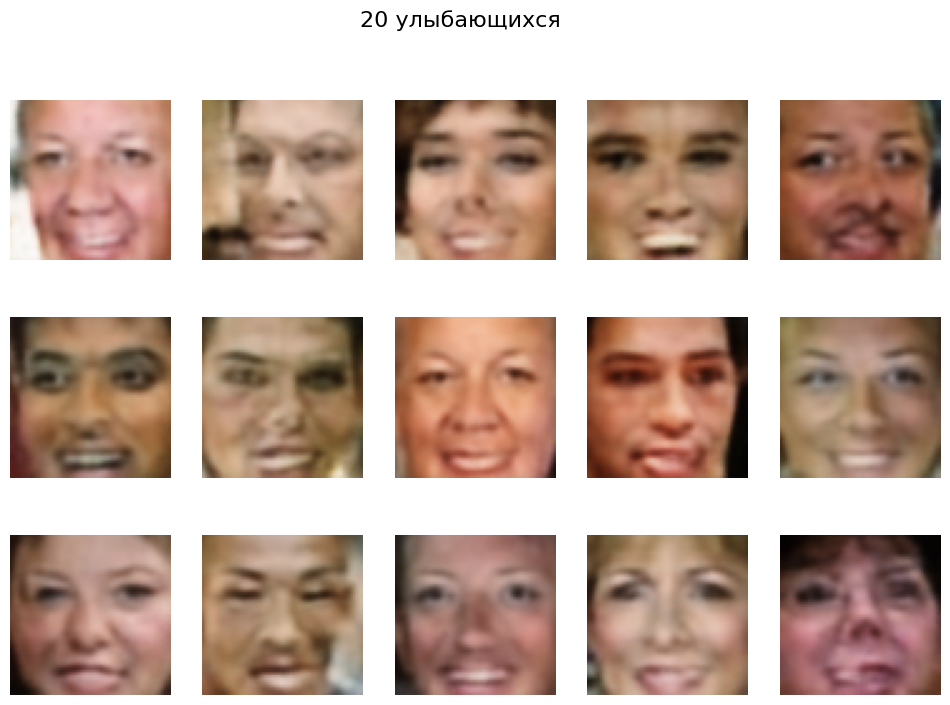

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
fig.suptitle('20 пририсованых улыбок', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_images[i])
    ax.set_axis_off()

plt.show()

In [ ]:
# Получилось жутковато...

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
import torchvision.transforms as transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128), 
            nn.Linear(128, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128), 
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), 
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512), 
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logvar):
    """
    Часть функции потерь, которая отвечает за "близость" латентных представлений разных объектов
    """
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def log_likelihood(x, reconstruction):
    """
    Часть функции потерь, которая отвечает за качество реконструкции
    """
    BCE = nn.functional.binary_cross_entropy(reconstruction, x.view(-1, 784), reduction='sum')
    return BCE

def loss_vae(x, mu, logvar, reconstruction):
    """
    Общая функция потерь
    """
    BCE = log_likelihood(x, reconstruction)
    KLD = KL_divergence(mu, logvar)
    return BCE + KLD

И обучим модель:

In [ ]:
criterion = loss_vae
vautoencoder = VAE()
optimizer = torch.optim.Adam(vautoencoder.parameters())
vautoencoder = vautoencoder.to(device)

100%|██████████| 313/313 [00:02<00:00, 117.53it/s]


Epoch 1/50: Train Loss=4845.6983, Val Loss=3783.6187


100%|██████████| 313/313 [00:02<00:00, 150.43it/s]


Epoch 2/50: Train Loss=3936.1632, Val Loss=3601.2479


100%|██████████| 313/313 [00:02<00:00, 125.14it/s]


Epoch 3/50: Train Loss=3810.2455, Val Loss=3508.8399


100%|██████████| 313/313 [00:01<00:00, 156.85it/s]


Epoch 4/50: Train Loss=3741.4103, Val Loss=3459.8665


100%|██████████| 313/313 [00:02<00:00, 117.46it/s]


Epoch 5/50: Train Loss=3691.5968, Val Loss=3424.8114


100%|██████████| 313/313 [00:02<00:00, 153.09it/s]


Epoch 6/50: Train Loss=3660.4756, Val Loss=3414.5162


100%|██████████| 313/313 [00:02<00:00, 153.01it/s]


Epoch 7/50: Train Loss=3633.4453, Val Loss=3413.2504


100%|██████████| 313/313 [00:02<00:00, 155.83it/s]


Epoch 8/50: Train Loss=3610.9683, Val Loss=3363.5253


100%|██████████| 313/313 [00:02<00:00, 118.59it/s]


Epoch 9/50: Train Loss=3588.9141, Val Loss=3358.5486


100%|██████████| 313/313 [00:02<00:00, 130.52it/s]


Epoch 10/50: Train Loss=3569.5732, Val Loss=3336.1067


100%|██████████| 313/313 [00:02<00:00, 151.29it/s]


Epoch 11/50: Train Loss=3556.1493, Val Loss=3337.5317


100%|██████████| 313/313 [00:02<00:00, 149.37it/s]


Epoch 12/50: Train Loss=3543.5228, Val Loss=3326.0569


100%|██████████| 313/313 [00:02<00:00, 151.50it/s]


Epoch 13/50: Train Loss=3531.8688, Val Loss=3318.9747


100%|██████████| 313/313 [00:02<00:00, 152.90it/s]


Epoch 14/50: Train Loss=3520.9925, Val Loss=3302.1991


100%|██████████| 313/313 [00:02<00:00, 150.48it/s]


Epoch 15/50: Train Loss=3508.9825, Val Loss=3297.9255


100%|██████████| 313/313 [00:02<00:00, 147.28it/s]


Epoch 16/50: Train Loss=3502.3617, Val Loss=3293.9967


100%|██████████| 313/313 [00:02<00:00, 127.55it/s]


Epoch 17/50: Train Loss=3489.7872, Val Loss=3330.0240


100%|██████████| 313/313 [00:02<00:00, 119.76it/s]


Epoch 18/50: Train Loss=3489.3691, Val Loss=3289.8920


100%|██████████| 313/313 [00:02<00:00, 143.47it/s]


Epoch 19/50: Train Loss=3479.8275, Val Loss=3279.3513


100%|██████████| 313/313 [00:02<00:00, 147.81it/s]


Epoch 20/50: Train Loss=3468.2056, Val Loss=3273.8956


100%|██████████| 313/313 [00:02<00:00, 147.17it/s]


Epoch 21/50: Train Loss=3464.6969, Val Loss=3300.6620


100%|██████████| 313/313 [00:02<00:00, 155.09it/s]


Epoch 22/50: Train Loss=3455.3126, Val Loss=3286.9545


100%|██████████| 313/313 [00:02<00:00, 147.34it/s]


Epoch 23/50: Train Loss=3450.6375, Val Loss=3270.1574


100%|██████████| 313/313 [00:02<00:00, 149.83it/s]


Epoch 24/50: Train Loss=3450.6328, Val Loss=3260.4563


100%|██████████| 313/313 [00:02<00:00, 116.58it/s]


Epoch 25/50: Train Loss=3444.5460, Val Loss=3251.1641


100%|██████████| 313/313 [00:02<00:00, 114.26it/s]


Epoch 26/50: Train Loss=3440.8953, Val Loss=3250.2654


100%|██████████| 313/313 [00:02<00:00, 115.69it/s]


Epoch 27/50: Train Loss=3431.8348, Val Loss=3246.3913


100%|██████████| 313/313 [00:02<00:00, 114.61it/s]


Epoch 28/50: Train Loss=3437.2342, Val Loss=3244.2526


100%|██████████| 313/313 [00:02<00:00, 121.41it/s]


Epoch 29/50: Train Loss=3425.4467, Val Loss=3245.7556


100%|██████████| 313/313 [00:02<00:00, 149.78it/s]


Epoch 30/50: Train Loss=3425.6138, Val Loss=3236.0468


100%|██████████| 313/313 [00:02<00:00, 151.75it/s]


Epoch 31/50: Train Loss=3420.3438, Val Loss=3242.5184


100%|██████████| 313/313 [00:02<00:00, 154.17it/s]


Epoch 32/50: Train Loss=3413.2942, Val Loss=3247.7233


100%|██████████| 313/313 [00:02<00:00, 150.61it/s]


Epoch 33/50: Train Loss=3414.0799, Val Loss=3226.8661


100%|██████████| 313/313 [00:02<00:00, 152.95it/s]


Epoch 34/50: Train Loss=3410.1861, Val Loss=3227.1461


100%|██████████| 313/313 [00:02<00:00, 148.72it/s]


Epoch 35/50: Train Loss=3407.3996, Val Loss=3224.8045


100%|██████████| 313/313 [00:02<00:00, 147.31it/s]


Epoch 36/50: Train Loss=3403.0009, Val Loss=3220.1520


100%|██████████| 313/313 [00:02<00:00, 125.98it/s]


Epoch 37/50: Train Loss=3396.7337, Val Loss=3215.5453


100%|██████████| 313/313 [00:02<00:00, 116.09it/s]


Epoch 38/50: Train Loss=3392.8219, Val Loss=3223.7193


100%|██████████| 313/313 [00:02<00:00, 140.67it/s]


Epoch 39/50: Train Loss=3390.4430, Val Loss=3223.9615


100%|██████████| 313/313 [00:02<00:00, 147.90it/s]


Epoch 40/50: Train Loss=3392.8024, Val Loss=3216.1239


100%|██████████| 313/313 [00:02<00:00, 146.13it/s]


Epoch 41/50: Train Loss=3390.6878, Val Loss=3224.9073


100%|██████████| 313/313 [00:02<00:00, 147.25it/s]


Epoch 42/50: Train Loss=3386.6412, Val Loss=3198.2294


100%|██████████| 313/313 [00:02<00:00, 144.90it/s]


Epoch 43/50: Train Loss=3383.5790, Val Loss=3213.8816


100%|██████████| 313/313 [00:02<00:00, 147.04it/s]


Epoch 44/50: Train Loss=3380.4519, Val Loss=3215.0114


100%|██████████| 313/313 [00:02<00:00, 149.10it/s]


Epoch 45/50: Train Loss=3379.9999, Val Loss=3202.5909


100%|██████████| 313/313 [00:02<00:00, 150.28it/s]


Epoch 46/50: Train Loss=3378.1829, Val Loss=3212.8824


100%|██████████| 313/313 [00:02<00:00, 123.05it/s]


Epoch 47/50: Train Loss=3375.9722, Val Loss=3207.5535


100%|██████████| 313/313 [00:02<00:00, 124.83it/s]


Epoch 48/50: Train Loss=3372.7188, Val Loss=3206.1966


100%|██████████| 313/313 [00:02<00:00, 148.90it/s]


Epoch 49/50: Train Loss=3371.9611, Val Loss=3209.5290


100%|██████████| 313/313 [00:02<00:00, 150.86it/s]


Epoch 50/50: Train Loss=3364.9759, Val Loss=3203.9294


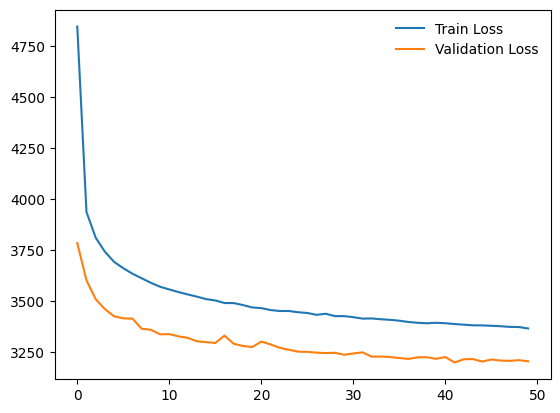

In [ ]:
train_losses = []
val_losses = []
epochs = 50

for epoch in range(epochs):
    vautoencoder.train()
    train_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        recon_img, mu, logvar = vautoencoder(img)
        loss = criterion(img, mu, logvar, recon_img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    vautoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            img, _ = data
            img = img.to(device)
            recon_img, mu, logvar = vautoencoder(img)
            loss = criterion(img, mu, logvar, recon_img)
            val_loss += loss.item() * img.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False)
plt.show() 

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

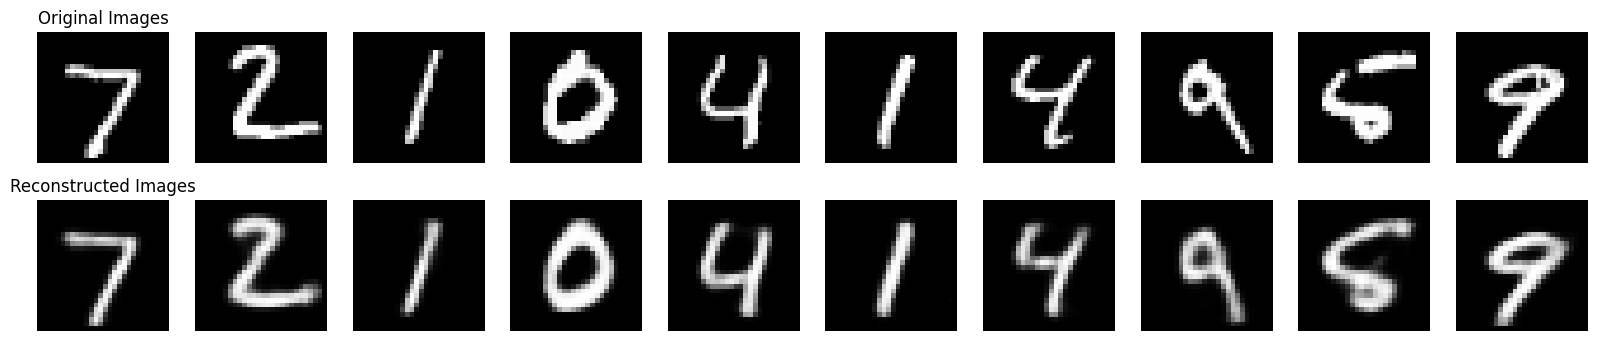

In [ ]:
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
count = 0
for batch in test_loader:
    images, _ = batch
    recon_images, _, _ = vautoencoder(images.to(device))
    for j in range(num_images):
        axes[0, count].imshow(images[j].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        axes[1, count].imshow(recon_images[j].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        count += 1
        if count >= num_images:
            break
    if count >= num_images:
        break

for i in range(2):
    for j in range(num_images):
        axes[i, j].axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')
plt.show()


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
z = np.random.randn(10, 20)
output = vautoencoder.decode(torch.FloatTensor(z).to(device))
output.shape

torch.Size([10, 784])

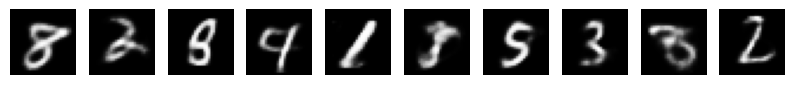

In [ ]:
z = np.random.randn(10, 20)
output = vautoencoder.decode(torch.FloatTensor(z).to(device)).cpu().detach().numpy()

plt.figure(figsize=(10, 2))
for i in range(output.shape[0]):
    plt.subplot(1, 10, i+1)
    plt.imshow(output[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

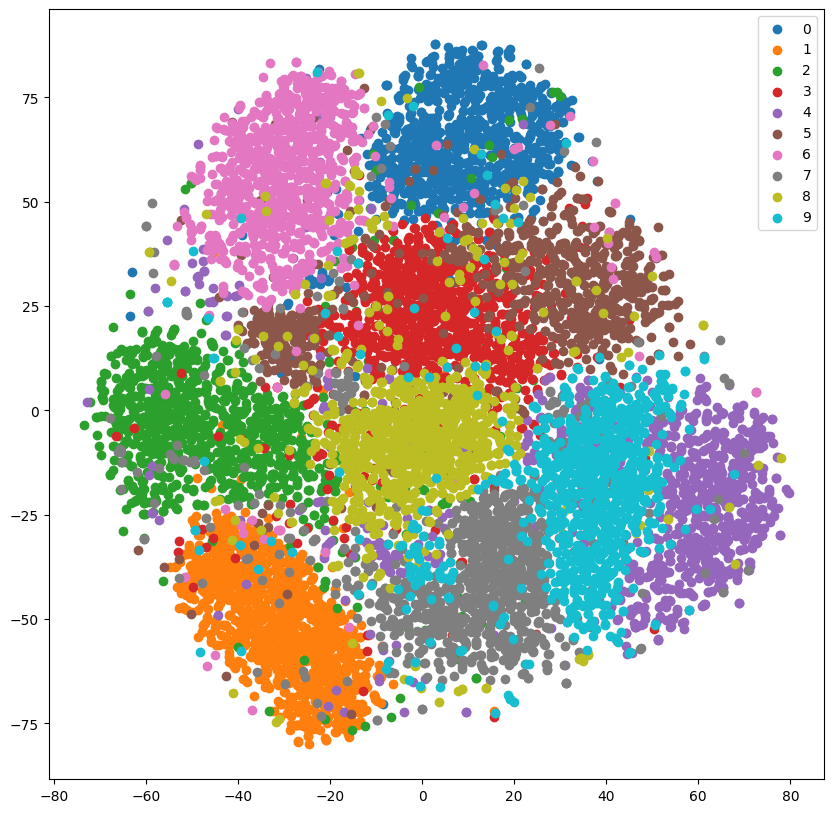

In [ ]:
# получение латентных представлений тестового датасета
latent_vectors = []
labels = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = vautoencoder.encode(data)
        z = vautoencoder.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())
        labels.append(target.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# применение TSNE для сжатия латентных представлений до двух измерений
tsne = TSNE(n_components=2)
latent_vectors_tsne = tsne.fit_transform(latent_vectors)

# визуализация точек на двумерной плоскости, разными цветами для разных цифр
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(latent_vectors_tsne[labels == i, 0], latent_vectors_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

Для реализации класса CVAE необходимо определить две архитектуры: encoder и decoder. Encoder должен кодировать изображение в две переменные - mu и logsigma. Декодер должен генерировать изображение на основе латентного вектора и класса картинки.

Кроме того, необходимо определить методы encode, gaussian_sampler, decode и forward, которые будут использоваться для обучения и генерации новых изображений. Метод encode должен возвращать mu, logsigma и класс картинки, метод gaussian_sampler - латентный вектор, метод decode - сгенерированное изображение, а метод forward - mu, logsigma и reconstruction.

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import torch

%matplotlib inline
random_state=69
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
batch_size = 32

class MNISTConcatDataset(Dataset):
    def __init__(self, dataset, one_hot_labels):
        self.dataset = dataset
        self.one_hot_labels = one_hot_labels
    
    def __getitem__(self, index):
        image, label = self.dataset[index]
        return torch.cat([image.view(-1), self.one_hot_labels[label]], dim=0)
    
    def __len__(self):
        return len(self.dataset)


def one_hot(label, num_classes=10):
    one_hot_label = torch.zeros(num_classes)
    one_hot_label[label] = 1.0
    return one_hot_label

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Concatenate one-hot labels and MNIST 
train_one_hot_labels = torch.stack([one_hot(label) for _, label in train_dataset])
test_one_hot_labels = torch.stack([one_hot(label) for _, label in test_dataset])

train_dataset = MNISTConcatDataset(train_dataset, train_one_hot_labels)
test_dataset = MNISTConcatDataset(test_dataset, test_one_hot_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class CVAE(nn.Module):

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.class_num = None 

            # Encoder
        self.encoder = nn.Sequential(
             nn.Flatten(),
             nn.Linear(784+10, 512),
             nn.ReLU(),
             nn.BatchNorm1d(512),            
             nn.Linear(512, 256),
             nn.ReLU(),
             nn.BatchNorm1d(256), 
             nn.Linear(256, 128),
             nn.ReLU(),
             nn.BatchNorm1d(128), 
             nn.Linear(128, latent_dim * 2)
             )
    
             # Decoder
        self.decoder = nn.Sequential(
             nn.Linear(latent_dim + 10, 128),
             nn.ReLU(),
             nn.BatchNorm1d(128), 
             nn.Linear(128, 256),
             nn.ReLU(),
             nn.BatchNorm1d(256), 
             nn.Linear(256, 512),
             nn.ReLU(),
             nn.BatchNorm1d(512), 
             nn.Linear(512, 784),
             nn.Sigmoid()
             )

    def encode(self, x):
        x, class_num = x[:, :784], x[:, 784:]
        self.class_num = class_num
        x = torch.cat([x, class_num.float()], 1)
        h = self.encoder(x)
        mu, logsigma = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logsigma, class_num



    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            z = mu + torch.randn_like(logsigma) * torch.exp(0.5 * logsigma)
        else:
            z = mu
        return z

    def decode(self, z, class_num):
        z_class = torch.cat([z, class_num], dim=1)
        reconstruction = self.decoder(z_class)
        return reconstruction


    def forward(self, x):
        mu, logsigma, class_num = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [ ]:
def loss_vae(x, mu, logvar, recon_x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [ ]:
model = CVAE(latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_function = loss_vae

In [ ]:
train_losses = []
val_losses = []
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for i, img in tqdm(enumerate(train_loader), total=len(train_loader)):
        img = img.to(device)
        opt.zero_grad()
        recon_img, mu, logvar = model(img)
        print(img.shape), print(img[:, :784].shape) ,print(recon_img.shape)
        loss = loss_vae(img[:, :784], mu, logvar, recon_img)
        loss.backward()
        opt.step()
        train_loss += loss.item() * img.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            img, _ = data
            img = img.to(device)
            recon_img, mu, logvar = model(img)
            loss = criterion(img, mu, logvar, recon_img)
            val_loss += loss.item() * img.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False)
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

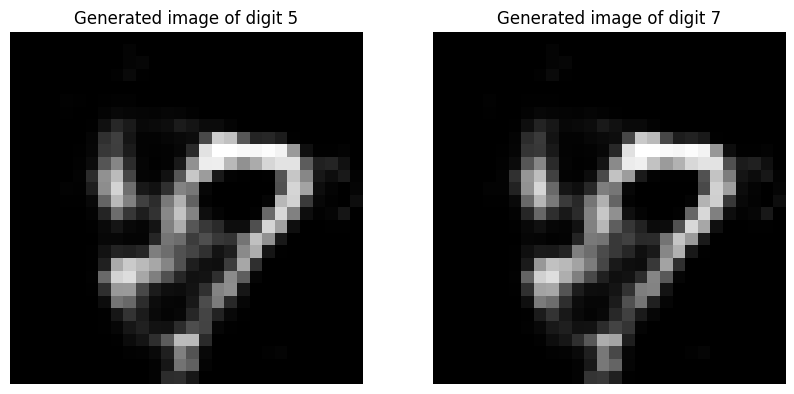

In [ ]:
# Получаем латентные вектора для цифр 5 и 7
z_5 = cvautoencoder.gaussian_sampler(torch.zeros(1, cvautoencoder.latent_dim), torch.zeros(1, cvautoencoder.latent_dim))
z_7 = cvautoencoder.gaussian_sampler(torch.zeros(1, cvautoencoder.latent_dim), torch.zeros(1, cvautoencoder.latent_dim))


# Получаем изображения, восстановленные из латентных векторов
img_5 = cvautoencoder.decode(z_5, torch.tensor([5]))
img_7 = cvautoencoder.decode(z_7, torch.tensor([7]))

# Визуализируем изображения
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_5.detach().numpy().reshape(28, 28), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Generated image of digit 5')
axs[1].imshow(img_7.detach().numpy().reshape(28, 28), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Generated image of digit 7')
plt.show()


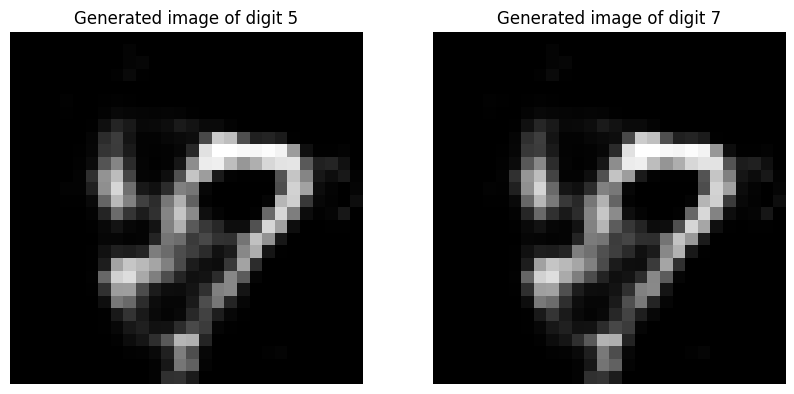

In [ ]:
# Генерация изображений цифр 5 и 7 из латентного пространства
with torch.no_grad():
    z_5 = cvautoencoder.gaussian_sampler(torch.zeros(1, cvautoencoder.latent_dim), torch.zeros(1, cvautoencoder.latent_dim))
    img_5 = cvautoencoder.decode(z_5, torch.tensor([5])).view(28, 28).cpu().numpy()

    z_7 = cvautoencoder.gaussian_sampler(torch.zeros(1, cvautoencoder.latent_dim), torch.zeros(1, cvautoencoder.latent_dim))
    img_7 = cvautoencoder.decode(z_7, torch.tensor([7])).view(28, 28).cpu().numpy()

# Отображение сгенерированных изображений
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_5, cmap='gray')
axs[0].set_title('Generated image of digit 5')
axs[0].axis('off')

axs[1].imshow(img_7, cmap='gray')
axs[1].set_title('Generated image of digit 7')
axs[1].axis('off')

plt.show()


In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>